# Levenberg Marquardt Fitting


## Conventions

-   S0 Signal for unbound state
-   S1 Signal for bound state
-   K equilibrium constant (Kd or pKa)
-   order data from unbound to bound (e.g. cl: 0–\>150 mM; pH 9–\>5)


In [1]:
import arviz as az
import corner
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sb

from clophfit.binding.fitting import Dataset, fit_binding_glob
from clophfit.binding.plotting import plot_emcee, print_emcee

%load_ext autoreload
%autoreload 2

## Single Cl titration.

<Axes: xlabel='cl', ylabel='F'>

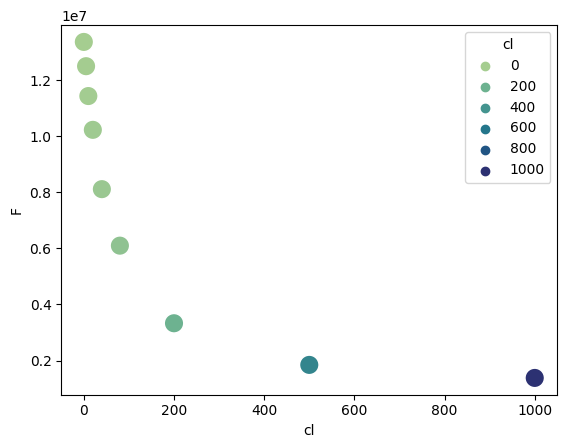

In [2]:
df = pd.read_table("../../tests/data/copyIP.txt")
sb.scatterplot(data=df, x="cl", y="F", hue=df.cl, palette="crest", s=200)

In general we can use either `lmfit.minimize() -> res` or `lmfit.Minimizer -> mini`.

[[Variables]]
    S0:  13408867.8 +/- 87130.3362 (0.65%) (init = 1.33579e+07)
    S1:  563537.064 +/- 106411.960 (18.88%) (init = 100)
    Kd:  58.3187767 +/- 2.24671605 (3.85%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(S1, Kd) = -0.7123
    C(S0, Kd) = -0.6562
    C(S0, S1) = +0.2747


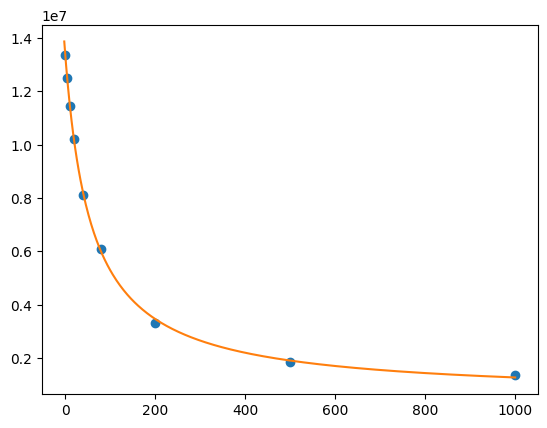

In [3]:
def residual(pars, x, y=None):
    S0 = pars["S0"]
    S1 = pars["S1"]
    Kd = pars["Kd"]
    model = (S0 + S1 * x / Kd) / (1 + x / Kd)
    if y is None:
        return model
    return y - model


params = lmfit.Parameters()
params.add("S0", value=df.F[0])
params.add("S1", value=100)
params.add("Kd", value=50, vary=True)
res = lmfit.minimize(residual, params, args=(df.cl, df.F))

xdelta = (df.cl.max() - df.cl.min()) / 500
xfit = np.arange(df.cl.min() - xdelta, df.cl.max() + xdelta, xdelta)
yfit = residual(res.params, xfit)
print(lmfit.fit_report(res.params))
plt.plot(df.cl, df.F, "o", xfit, yfit, "-")

In [4]:
mini = lmfit.Minimizer(residual, params, fcn_args=(df.cl, df.F))
res = mini.minimize()
ci, tr = lmfit.conf_interval(mini, res, sigmas=[0.68, 0.95], trace=True)
print(lmfit.ci_report(ci, with_offset=False, ndigits=2))
print(lmfit.fit_report(res, show_correl=False, sort_pars=True))

    95.00% 68.00% _BEST_ 68.00% 95.00%
 S0:13197616.3413314946.3513408867.7913503300.3813622729.13
 S1:300911.47447991.63563537.06677869.66819977.61
 Kd:  53.13  55.96  58.32  60.79  64.07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 9
    # variables        = 3
    chi-square         = 8.3839e+10
    reduced chi-square = 1.3973e+10
    Akaike info crit   = 212.594471
    Bayesian info crit = 213.186145
[[Variables]]
    Kd:  58.3187767 +/- 2.24671605 (3.85%) (init = 50)
    S0:  13408867.8 +/- 87130.3362 (0.65%) (init = 1.33579e+07)
    S1:  563537.064 +/- 106411.960 (18.88%) (init = 100)


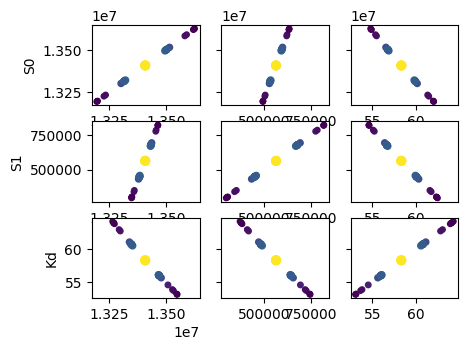

In [5]:
names = res.params.keys()
i = 0
gs = plt.GridSpec(4, 4)
sx = {}
sy = {}
for fixed in names:
    j = 0
    for free in names:
        if j in sx and i in sy:
            ax = plt.subplot(gs[i, j], sharex=sx[j], sharey=sy[i])
        elif i in sy:
            ax = plt.subplot(gs[i, j], sharey=sy[i])
            sx[j] = ax
        elif j in sx:
            ax = plt.subplot(gs[i, j], sharex=sx[j])
            sy[i] = ax
        else:
            ax = plt.subplot(gs[i, j])
            sy[i] = ax
            sx[j] = ax
        if i < 3:
            plt.setp(ax.get_xticklabels(), visible=True)
        else:
            ax.set_xlabel(free)

        if j > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel(fixed)

        rest = tr[fixed]
        prob = rest["prob"]
        f = prob < 0.96

        x, y = rest[free], rest[fixed]
        ax.scatter(x[f], y[f], c=1 - prob[f], s=25 * (1 - prob[f] + 0.5))
        ax.autoscale(1, 1)
        j += 1
    i += 1

The plots shown below, akin to the examples provided in [lmfit documentation](https://lmfit.github.io/lmfit-py/examples/example_confidence_interval.html#sphx-glr-examples-example-confidence-interval-py), are computationally intensive. They operate under the assumption of a parabolic parameter space. However, it's worth noting that these plots provide similar information to that yielded by a Monte Carlo simulation.

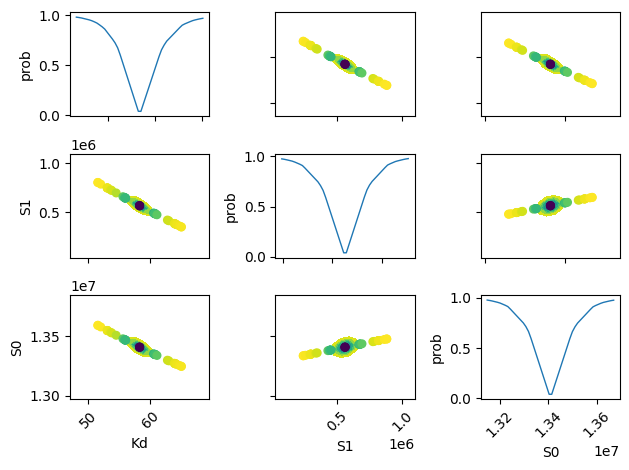

In [6]:
names = list(res.params.keys())

plt.figure()
for i in range(3):
    for j in range(3):
        indx = 9 - j * 3 - i
        ax = plt.subplot(3, 3, indx)
        ax.ticklabel_format(style="sci", scilimits=(-2, 2), axis="y")

        # set-up labels and tick marks
        ax.tick_params(labelleft=False, labelbottom=False)
        if indx in (1, 4, 7):
            plt.ylabel(names[j])
            ax.tick_params(labelleft=True)
        if indx == 1:
            ax.tick_params(labelleft=True)
        if indx in (7, 8, 9):
            plt.xlabel(names[i])
            ax.tick_params(labelbottom=True)
            [label.set_rotation(45) for label in ax.get_xticklabels()]

        if i != j:
            x, y, m = lmfit.conf_interval2d(mini, res, names[i], names[j], 20, 20)
            plt.contourf(x, y, m, np.linspace(0, 1, 10))

            x = tr[names[i]][names[i]]
            y = tr[names[i]][names[j]]
            pr = tr[names[i]]["prob"]
            s = np.argsort(x)
            plt.scatter(x[s], y[s], c=pr[s], s=30, lw=1)

        else:
            x = tr[names[i]][names[i]]
            y = tr[names[i]]["prob"]

            t, s = np.unique(x, True)
            f = scipy.interpolate.interp1d(t, y[s], "slinear")
            xn = np.linspace(x.min(), x.max(), 50)
            plt.plot(xn, f(xn), lw=1)
            plt.ylabel("prob")
            ax.tick_params(labelleft=True)

plt.tight_layout()

[[Variables]]
    S0:  13408867.8 +/- 87130.3362 (0.65%) (init = 1.33579e+07)
    S1:  563537.064 +/- 106411.960 (18.88%) (init = 100)
    Kd:  58.3187767 +/- 2.24671605 (3.85%) (init = 50)
[[Correlations]] (unreported correlations are < 0.250)
    C(S1, Kd) = -0.7123
    C(S0, Kd) = -0.6562
    C(S0, S1) = +0.2747
       95.45%    68.27%    _BEST_    68.27%    95.45%
 S0:-217226.68396-94491.4465413408867.78780+95008.79622+219988.97145
 S1:-270193.31665-116252.05686563537.06417+115024.41865+263650.82003
 Kd:  -5.32812  -2.37783  58.31878  +2.48963  +5.92424


Text(0, 0.5, 'Kd')

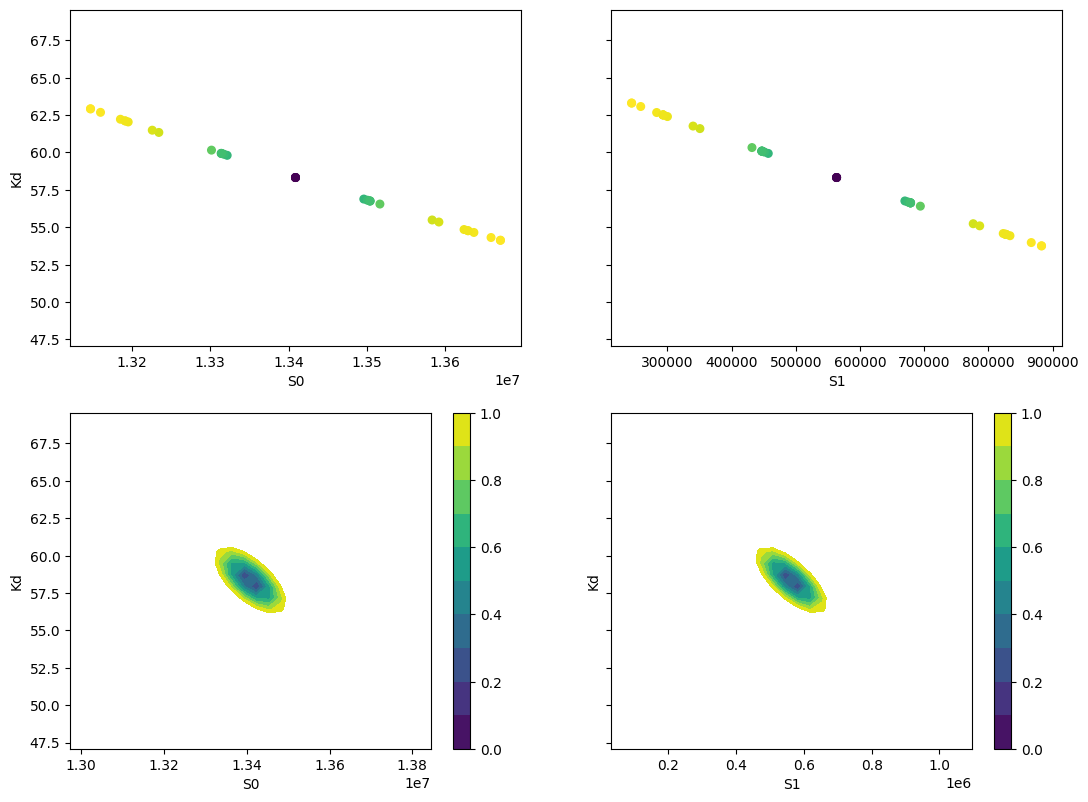

In [7]:
lmfit.report_fit(res.params, min_correl=0.25)

ci, trace = lmfit.conf_interval(mini, res, sigmas=[1, 2], trace=True)
lmfit.printfuncs.report_ci(ci)

fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6), sharey=True)
cx1, cy1, prob = trace["S0"]["S0"], trace["S0"]["Kd"], trace["S0"]["prob"]
cx2, cy2, prob2 = trace["S1"]["S1"], trace["S1"]["Kd"], trace["S1"]["prob"]

axes[0][0].scatter(cx1, cy1, c=prob, s=30)
axes[0][0].set_xlabel("S0")
axes[0][0].set_ylabel("Kd")

axes[0][1].scatter(cx2, cy2, c=prob2, s=30)
axes[0][1].set_xlabel("S1")

cx, cy, grid = lmfit.conf_interval2d(mini, res, "S0", "Kd", 30, 30)
ctp = axes[1][0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1][0])
axes[1][0].set_xlabel("S0")
axes[1][0].set_ylabel("Kd")

cx, cy, grid = lmfit.conf_interval2d(mini, res, "S1", "Kd", 30, 30)
ctp = axes[1][1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1][1])
axes[1][1].set_xlabel("S1")
axes[1][1].set_ylabel("Kd")

Text(0, 0.5, 'S1')

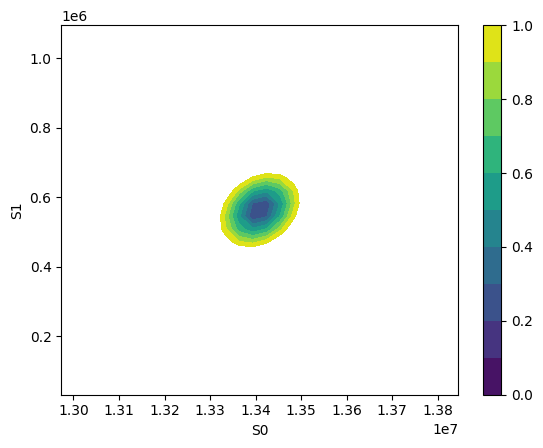

In [8]:
x, y, grid = lmfit.conf_interval2d(mini, res, "S0", "S1", 30, 30)
plt.contourf(x, y, grid, np.linspace(0, 1, 11))
plt.xlabel("S0")
plt.colorbar()
plt.ylabel("S1")

### Using clophfit.binding

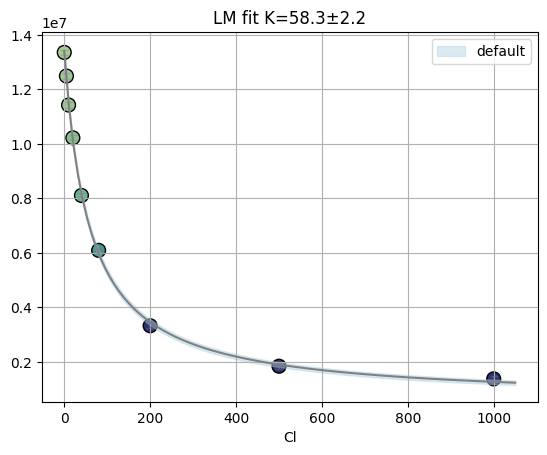

In [9]:
ds = Dataset(df["cl"].to_numpy(), df["F"].to_numpy())
f_res = fit_binding_glob(ds, weighting=True)

f_res.figure

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 89.58it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [23.92586381 44.3333056  43.89306553]
[49.5, 61.5]


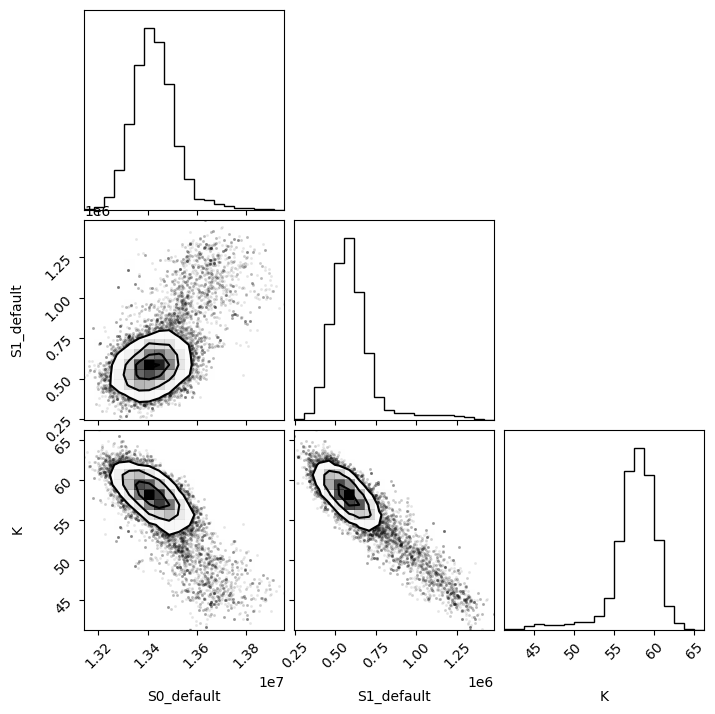

In [10]:
emcee_res = f_res.mini.emcee(steps=400, burn=50, workers=8)
print(plot_emcee(emcee_res)[1])

## Fit titration with multiple datasets

For example data collected with multiple labelblocks in Tecan plate reader.

“A01”: pH titration with y1 and y2.

In [11]:
df = pd.read_csv("../../tests/data/A01.dat", sep=" ", names=["x", "y1", "y2"])
df = df[::-1].reset_index(drop=True)
df

,x,y1,y2
0,9.030000,29657.0,22885.0
1,8.373333,35200.0,16930.0
2,7.750000,44901.0,9218.0
3,7.073333,53063.0,3758.0
4,6.460000,54202.0,2101.0
5,5.813333,54851.0,1542.0
6,4.996667,51205.0,1358.0


### lmfit of single y1 using analytical Jacobian

It computes the Jacobian of the fz. Mind that the residual (i.e. y - fz)
will be actually minimized.

In [12]:
import sympy

x, S0_1, S1_1, K = sympy.symbols("x S0_1 S1_1 K")
f = (S0_1 + S1_1 * 10 ** (K - x)) / (1 + 10 ** (K - x))
print(sympy.diff(f, S0_1))
print(sympy.diff(f, S1_1))
print(sympy.diff(f, K))

1/(10**(K - x) + 1)
10**(K - x)/(10**(K - x) + 1)
10**(K - x)*S1_1*log(10)/(10**(K - x) + 1) - 10**(K - x)*(10**(K - x)*S1_1 + S0_1)*log(10)/(10**(K - x) + 1)**2


In [13]:
x, S0, S1, K = sympy.symbols("x S0 S1 K")
f = S0 + (S1 - S0) * x / K / (1 + x / K)
sympy.diff(f, S0)

1 - x/(K*(1 + x/K))

In [14]:
sympy.diff(f, S1)

x/(K*(1 + x/K))

In [15]:
sympy.diff(f, K)

-x*(-S0 + S1)/(K**2*(1 + x/K)) + x**2*(-S0 + S1)/(K**3*(1 + x/K)**2)

In [16]:
# if is_ph:
f = S0 + (S1 - S0) * 10 ** (K - x) / (1 + 10 ** (K - x))
sympy.diff(f, S0)

-10**(K - x)/(10**(K - x) + 1) + 1

In [17]:
sympy.diff(f, S1)

10**(K - x)/(10**(K - x) + 1)

In [18]:
sympy.diff(f, K)

10**(K - x)*(-S0 + S1)*log(10)/(10**(K - x) + 1) - 10**(2*K - 2*x)*(-S0 + S1)*log(10)/(10**(K - x) + 1)**2

In [19]:
def residual(pars, x, data):
    S0 = pars["S0"]
    S1 = pars["S1"]
    K = pars["K"]
    # model = (S0 + S1 * x / Kd) / (1 + x / Kd)
    x = np.array(x)
    y = np.array(data)
    model = (S0 + S1 * 10 ** (K - x)) / (1 + 10 ** (K - x))
    if data is None:
        return model
    return y - model


# Try Jacobian
def dfunc(pars, x, data=None):
    S0_1 = pars["S0"]
    S1_1 = pars["S1"]
    K = pars["K"]
    kx = np.array(10 ** (K - x))
    return np.array(
        [
            -1 / (kx + 1),
            -kx / (kx + 1),
            -kx * np.log(10) * (S1_1 / (kx + 1) - (kx * S1_1 + S0_1) / (kx + 1) ** 2),
        ]
    )


params = lmfit.Parameters()
params.add("S0", value=25000)
params.add("S1", value=50000, min=0.0)
params.add("K", value=7, min=2.0, max=12.0)

mini = lmfit.Minimizer(residual, params, fcn_args=(df.x,), fcn_kws={"data": df.y1})
res = mini.leastsq(Dfun=dfunc, col_deriv=True, ftol=1e-8)
print(lmfit.report_fit(res))
ci = lmfit.conf_interval(mini, res, sigmas=[1, 2, 3])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
[[Variables]]
    S0:  26638.8377 +/- 2455.91825 (9.22%) (init = 25000)
    S1:  54043.3592 +/- 979.995977 (1.81%) (init = 50000)
    K:   8.06961091 +/- 0.14940678 (1.85%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(S0, K)  = -0.7750
    C(S1, K)  = -0.4552
    C(S0, S1) = +0.2046
None


In [20]:
print(lmfit.ci_report(ci, with_offset=False, ndigits=2))

    99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 S0:-58596.9018262.4323743.2826638.8429197.6132638.1538999.44
 S1:47850.5551309.0552945.1454043.3655156.5456872.9060768.74
 K :   7.09   7.67   7.91   8.07   8.23   8.50   9.58


### using lmfit with np.r_ trick

In [21]:
def residual2(pars, x, data=None):
    K = pars["K"]
    S0_1 = pars["S0_1"]
    S1_1 = pars["S1_1"]
    S0_2 = pars["S0_2"]
    S1_2 = pars["S1_2"]
    model_0 = (S0_1 + S1_1 * 10 ** (K - x[0])) / (1 + 10 ** (K - x[0]))
    model_1 = (S0_2 + S1_2 * 10 ** (K - x[1])) / (1 + 10 ** (K - x[1]))
    if data is None:
        return np.r_[model_0, model_1]
    return np.r_[data[0] - model_0, data[1] - model_1]


params2 = lmfit.Parameters()
params2.add("K", value=7.0, min=2.0, max=12.0)
params2.add("S0_1", value=df.y1[0], min=0.0)
params2.add("S0_2", value=df.y2[0], min=0.0)
params2.add("S1_1", value=df.y1.iloc[-1], min=0.0)
params2.add("S1_2", value=df.y2.iloc[-1], min=0.0)
mini2 = lmfit.Minimizer(
    residual2, params2, fcn_args=([df.x, df.x],), fcn_kws={"data": [df.y1, df.y2]}
)
res2 = mini2.minimize()
print(lmfit.fit_report(res2))

ci2, tr2 = lmfit.conf_interval(mini2, res2, sigmas=[0.68, 0.95], trace=True)
print(lmfit.ci_report(ci2, with_offset=False, ndigits=2))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 14
    # variables        = 5
    chi-square         = 12471473.3
    reduced chi-square = 1385719.25
    Akaike info crit   = 201.798560
    Bayesian info crit = 204.993846
[[Variables]]
    K:     8.07255029 +/- 0.07600777 (0.94%) (init = 7)
    S0_1:  26601.3458 +/- 1425.69913 (5.36%) (init = 29657)
    S0_2:  25084.4189 +/- 1337.07982 (5.33%) (init = 22885)
    S1_1:  54034.5806 +/- 627.642479 (1.16%) (init = 51205)
    S1_2:  1473.57871 +/- 616.944649 (41.87%) (init = 1358)
[[Correlations]] (unreported correlations are < 0.100)
    C(K, S0_1)    = -0.6816
    C(K, S0_2)    = +0.6255
    C(S0_1, S0_2) = -0.4264
    C(K, S1_1)    = -0.3611
    C(K, S1_2)    = +0.3161
    C(S0_2, S1_1) = -0.2259
    C(S0_1, S1_2) = -0.2155
    C(S1_1, S1_2) = -0.1141
      95.00% 68.00% _BEST_ 68.00% 95.00%
 K   :   7.91   7.99   8.07   8.15   8.24
 S0_1:23210.9025078.6226601.3528045.4929623.53
 S

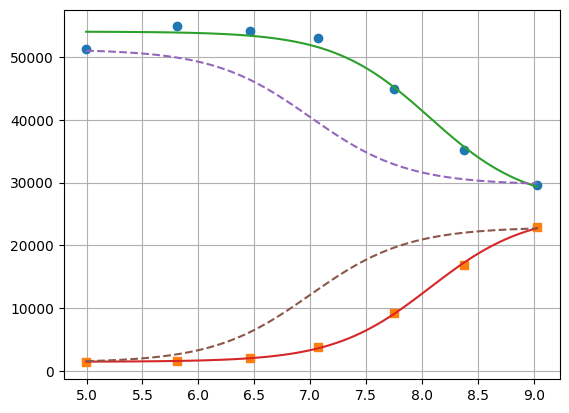

In [22]:
xfit = np.linspace(df.x.min(), df.x.max(), 100)
yfit0 = residual2(params2, [xfit, xfit])
yfit0 = yfit0.reshape(2, 100)
yfit = residual2(res2.params, [xfit, xfit])
yfit = yfit.reshape(2, 100)
plt.plot(df.x, df.y1, "o", df.x, df.y2, "s")
plt.plot(xfit, yfit[0], "-", xfit, yfit[1], "-")
plt.plot(xfit, yfit0[0], "--", xfit, yfit0[1], "--")
plt.grid(True)

### lmfit constraints aiming for generality

I believe a name convention would be more robust than relying on
OrderedDict Params object.

In [23]:
"S0_1".split("_")[0]

'S0'

In [24]:
def exception_fcn_handler(func):
    def inner_function(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except TypeError:
            print(
                f"{func.__name__} only takes (1D) vector as argument besides lmfit.Parameters."
            )

    return inner_function


@exception_fcn_handler
def titration_pH(params, pH):
    p = {k.split("_")[0]: v for k, v in params.items()}
    return (p["S0"] + p["S1"] * 10 ** (p["K"] - pH)) / (1 + 10 ** (p["K"] - pH))


def residues(params, x, y, fcn):
    return y - fcn(params, x)


p1 = lmfit.Parameters()
p2 = lmfit.Parameters()
p1.add("K_1", value=7.0, min=2.0, max=12.0)
p2.add("K_2", value=7.0, min=2.0, max=12.0)
p1.add("S0_1", value=df.y1.iloc[0], min=0.0)
p2.add("S0_2", value=df.y2.iloc[0], min=0.0)
p1.add("S1_1", value=df.y1.iloc[-1], min=0.0)
p2.add("S1_2", value=df.y2.iloc[-1])

print(
    residues(p1, np.array(df.x), [1.97, 1.8, 1.7, 0.1, 0.1, 0.16, 0.01], titration_pH)
)


def gobjective(params, xl, yl, fcnl):
    nset = len(xl)
    res = []
    for i in range(nset):
        pi = {k: v for k, v in params.valuesdict().items() if k[-1] == f"{i+1}"}
        res = np.r_[res, residues(pi, xl[i], yl[i], fcnl[i])]
        # res = np.r_[res, yl[i] - fcnl[i](parsl[i], x[i])]
    return res


print(gobjective(p1 + p2, [df.x, df.x], [df.y1, df.y2], [titration_pH, titration_pH]))

[-29854.26823732 -30530.32007939 -32908.60749879 -39523.42660007
 -46381.47878947 -49888.5091843  -50993.25866394]
[  -199.23823732   4667.87992061  11990.69250121  13539.47339993
   7820.42121053   4962.3308157     211.73133606    199.04406603
  -5080.73278499 -10416.86307191  -9270.08900503  -4075.72045662
  -1131.04796128   -211.52498939]


Here single.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
[[Variables]]
    K_1:   8.06961042 +/- 0.14940740 (1.85%) (init = 7)
    S0_1:  26638.8440 +/- 2455.92762 (9.22%) (init = 29657)
    S1_1:  54043.3607 +/- 979.995185 (1.81%) (init = 51205)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_1, S0_1)  = -0.7750
    C(K_1, S1_1)  = -0.4552
    C(S0_1, S1_1) = +0.2046
None
         95.45%    68.27%    _BEST_    68.27%    95.45%
 K_1 :  -0.40197  -0.15948   8.06961  +0.16276  +0.42592
 S0_1:-8376.39586-2895.5681226638.84401+2558.76794+5999.32366
 S1_1:-2734.30835-1098.2218354043.36069+1113.18102+2829.55353


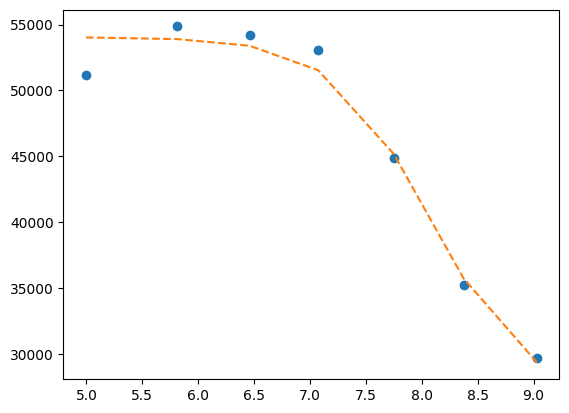

In [25]:
mini = lmfit.Minimizer(
    residues,
    p1,
    fcn_args=(
        df.x,
        df.y1,
        titration_pH,
    ),
)
res = mini.minimize()

fit = titration_pH(res.params, df.x)
print(lmfit.report_fit(res))
plt.plot(df.x, df.y1, "o", df.x, fit, "--")
ci = lmfit.conf_interval(mini, res, sigmas=[1, 2])
lmfit.printfuncs.report_ci(ci)

Now global.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 14
    # variables        = 5
    chi-square         = 12471473.3
    reduced chi-square = 1385719.25
    Akaike info crit   = 201.798560
    Bayesian info crit = 204.993846
[[Variables]]
    K_1:   8.07255029 +/- 0.07600777 (0.94%) (init = 7)
    S0_1:  26601.3458 +/- 1425.69913 (5.36%) (init = 29657)
    S1_1:  54034.5806 +/- 627.642480 (1.16%) (init = 51205)
    K_2:   8.07255029 +/- 0.07600777 (0.94%) == 'K_1'
    S0_2:  25084.4189 +/- 1337.07982 (5.33%) (init = 22885)
    S1_2:  1473.57871 +/- 616.944649 (41.87%) (init = 1358)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_1, S0_1)  = -0.6816
    C(K_1, S0_2)  = +0.6255
    C(S0_1, S0_2) = -0.4264
    C(K_1, S1_1)  = -0.3611
    C(K_1, S1_2)  = +0.3161
    C(S1_1, S0_2) = -0.2259
    C(S0_1, S1_2) = -0.2155
    C(S1_1, S1_2) = -0.1141


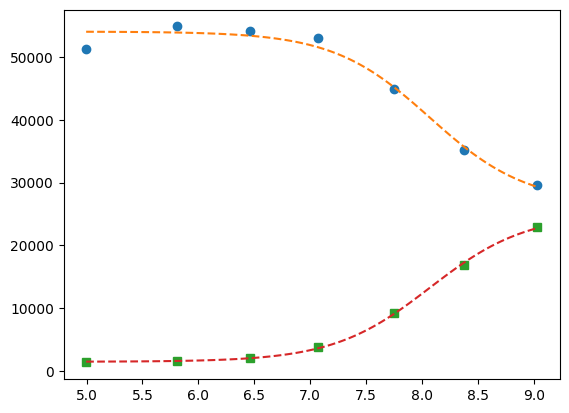

In [26]:
pg = p1 + p2
pg["K_2"].expr = "K_1"
gmini = lmfit.Minimizer(
    gobjective,
    pg,
    fcn_args=([df.x[:], df.x], [df.y1[:], df.y2], [titration_pH, titration_pH]),
)
gres = gmini.minimize()
print(lmfit.fit_report(gres))

pp1 = {k: v for k, v in gres.params.valuesdict().items() if k.split("_")[1] == f"{1}"}
pp2 = {k: v for k, v in gres.params.valuesdict().items() if k.split("_")[1] == f"{2}"}
xfit = np.linspace(df.x.min(), df.x.max(), 100)
yfit1 = titration_pH(pp1, xfit)
yfit2 = titration_pH(pp2, xfit)
plt.plot(df.x, df.y1, "o", xfit, yfit1, "--")
plt.plot(df.x, df.y2, "s", xfit, yfit2, "--")

In [27]:
ci = lmfit.conf_interval(gmini, gres)
print(lmfit.ci_report(ci, with_offset=False, ndigits=2))

      99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 K_1 :   7.77   7.90   7.99   8.07   8.15   8.25   8.38
 S0_1:20066.1223118.2625069.3726601.3528053.8229696.8331876.24
 S1_1:51504.2152593.4753374.3654034.5854699.1855496.7856630.81
 S0_2:20096.2422163.6223716.0825084.4226523.5528350.2131192.55
 S1_2:-1078.82  36.05 820.171473.582122.782890.883962.77


To plot ci for the 5 parameters.

Text(0, 0.5, 'pK1')

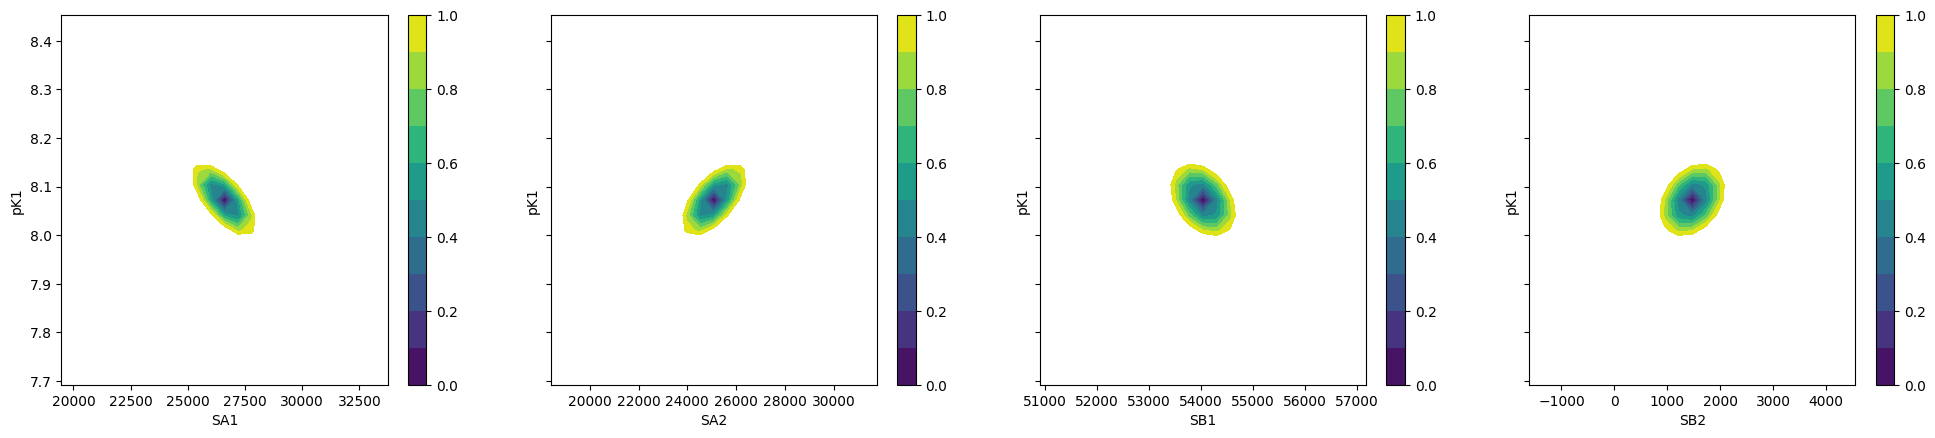

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(24.2, 4.8), sharey=True)
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S0_1", "K_1", 25, 25)
ctp = axes[0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[0])
axes[0].set_xlabel("SA1")
axes[0].set_ylabel("pK1")
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S0_2", "K_1", 25, 25)
ctp = axes[1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1])
axes[1].set_xlabel("SA2")
axes[1].set_ylabel("pK1")
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S1_1", "K_1", 25, 25)
ctp = axes[2].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[2])
axes[2].set_xlabel("SB1")
axes[2].set_ylabel("pK1")
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S1_2", "K_1", 25, 25)
ctp = axes[3].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[3])
axes[3].set_xlabel("SB2")
axes[3].set_ylabel("pK1")

943.8323579301886


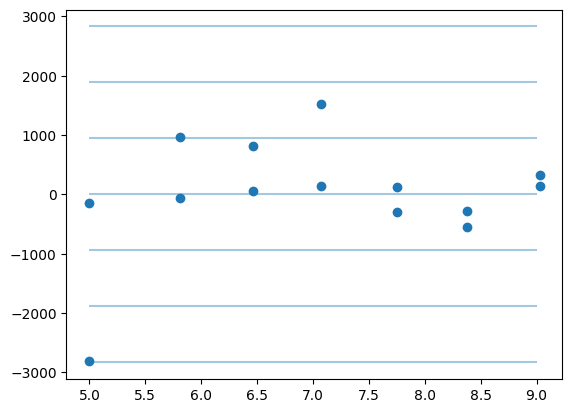

In [29]:
plt.plot(np.r_[df.x, df.x], gres.residual, "o")
std = gres.residual.std()
for i in range(-3, 4):
    plt.hlines(i * std, 5, 9, alpha=0.4)
print(std)

This next block comes from:
<https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html?highlight=emcee>

### lmfit.Model

It took 9 vs 5 ms. It is not possible to do global fitting. In the
documentation it is stressed the need to convert the output of the
residue to be 1D vectors.

In [30]:
mod = lmfit.models.ExpressionModel("(SB + SA * 10**(pK-x)) / (1 + 10**(pK-x))")
result = mod.fit(np.array(df.y1), x=np.array(df.x), pK=7, SB=7e3, SA=10000)
print(result.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
    R-squared          = 0.97973543
[[Variables]]
    SB:  26638.9314 +/- 2456.05773 (9.22%) (init = 7000)
    SA:  54043.3812 +/- 979.984193 (1.81%) (init = 10000)
    pK:  8.06960356 +/- 0.14941163 (1.85%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(SB, pK) = -0.7750
    C(SA, pK) = -0.4552
    C(SB, SA) = +0.2046


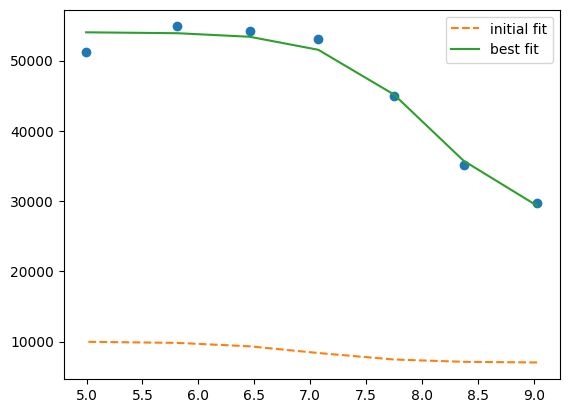

In [31]:
plt.plot(df.x, df.y1, "o")
plt.plot(df.x, result.init_fit, "--", label="initial fit")
plt.plot(df.x, result.best_fit, "-", label="best fit")
plt.legend()

In [32]:
print(result.ci_report())

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 SB:-85235.83517-8376.49744-2895.6555126638.93141+2558.68054+5999.21905+12360.51318
 SA:-6192.83614-2734.32819-1098.2423854043.38116+1113.16062+2829.52103+6725.35644
 pK:  -0.98138  -0.40196  -0.15948   8.06960  +0.16277  +0.42592  +1.50919


which is faster but still I failed to find the way to global fitting.

In [33]:
def tit_pH(x, S0, S1, K):
    return (S0 + S1 * 10 ** (K - x)) / (1 + 10 ** (K - x))


tit_model1 = lmfit.Model(tit_pH, prefix="ds1_")
tit_model2 = lmfit.Model(tit_pH, prefix="ds2_")
print(f"parameter names: {tit_model1.param_names}")
print(f"parameter names: {tit_model2.param_names}")
print(f"independent variables: {tit_model1.independent_vars}")
print(f"independent variables: {tit_model2.independent_vars}")

tit_model1.set_param_hint("K", value=7.0, min=2.0, max=12.0)
tit_model1.set_param_hint("S0", value=df.y1[0], min=0.0)
tit_model1.set_param_hint("S1", value=df.y1.iloc[-1], min=0.0)
tit_model2.set_param_hint("K", value=7.0, min=2.0, max=12.0)
tit_model2.set_param_hint("S0", value=df.y1[0], min=0.0)
tit_model2.set_param_hint("S1", value=df.y1.iloc[-1], min=0.0)
pars1 = tit_model1.make_params()
pars2 = tit_model2.make_params()
# gmodel = tit_model1 + tit_model2
# result = gmodel.fit(df.y1 + df.y2, pars, x=df.x)
res1 = tit_model1.fit(df.y1, pars1, x=df.x)
res2 = tit_model2.fit(df.y2, pars2, x=df.x)
print(res1.fit_report())
print(res2.fit_report())

parameter names: ['ds1_S0', 'ds1_S1', 'ds1_K']
parameter names: ['ds2_S0', 'ds2_S1', 'ds2_K']
independent variables: ['x']
independent variables: ['x']
[[Model]]
    Model(tit_pH, prefix='ds1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
    R-squared          = 0.97973543
[[Variables]]
    ds1_S0:  26638.8440 +/- 2455.92762 (9.22%) (init = 29657)
    ds1_S1:  54043.3607 +/- 979.995185 (1.81%) (init = 51205)
    ds1_K:   8.06961042 +/- 0.14940740 (1.85%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(ds1_S0, ds1_K)  = -0.7750
    C(ds1_S1, ds1_K)  = -0.4552
    C(ds1_S0, ds1_S1) = +0.2046
[[Model]]
    Model(tit_pH, prefix='ds2_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points    

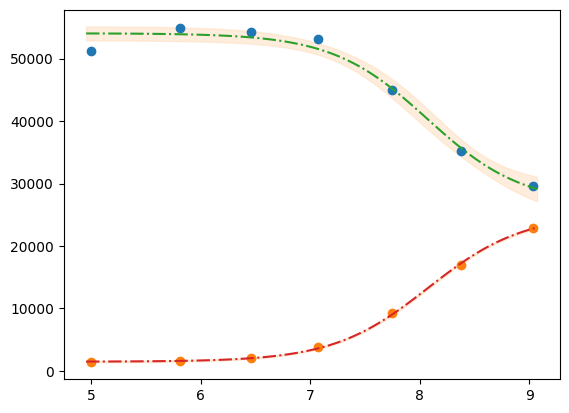

In [34]:
xfit_delta = (df.x.max() - df.x.min()) / 100
xfit = np.arange(df.x.min() - xfit_delta, df.x.max() + xfit_delta, xfit_delta)
dely1 = res1.eval_uncertainty(x=xfit) * 1
dely2 = res2.eval_uncertainty(x=xfit) * 1
best_fit1 = res1.eval(x=xfit)
best_fit2 = res2.eval(x=xfit)
plt.plot(df.x, df.y1, "o")
plt.plot(df.x, df.y2, "o")
plt.plot(xfit, best_fit1, "-.")
plt.plot(xfit, best_fit2, "-.")
plt.fill_between(xfit, best_fit1 - dely1, best_fit1 + dely1, color="#FEDCBA", alpha=0.5)
plt.fill_between(xfit, best_fit2 - dely2, best_fit2 + dely2, color="#FEDCBA", alpha=0.5)

Please mind the difference in the uncertainty between the 2 label
blocks.

In [35]:
def tit_pH2(x, S0_1, S0_2, S1_1, S1_2, K):
    y1 = (S0_1 + S1_1 * 10 ** (K - x)) / (1 + 10 ** (K - x))
    y2 = (S0_2 + S1_2 * 10 ** (K - x)) / (1 + 10 ** (K - x))
    # return y1, y2
    return np.r_[y1, y2]


tit_model = lmfit.Model(tit_pH2)
tit_model.set_param_hint("K", value=7.0, min=2.0, max=12.0)
tit_model.set_param_hint("S0_1", value=df.y1[0], min=0.0)
tit_model.set_param_hint("S0_2", value=df.y2[0], min=0.0)
tit_model.set_param_hint("S1_1", value=df.y1.iloc[-1], min=0.0)
tit_model.set_param_hint("S1_2", value=df.y2.iloc[-1], min=0.0)
pars = tit_model.make_params()
# res = tit_model.fit([df.y1, df.y2], pars, x=df.x)
res = tit_model.fit(np.r_[df.y1, df.y2], pars, x=df.x)
print(res.fit_report())

[[Model]]
    Model(tit_pH2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 14
    # variables        = 5
    chi-square         = 12471473.3
    reduced chi-square = 1385719.25
    Akaike info crit   = 201.798560
    Bayesian info crit = 204.993846
    R-squared          = 0.99794717
[[Variables]]
    S0_1:  26601.3458 +/- 1425.69913 (5.36%) (init = 29657)
    S0_2:  25084.4189 +/- 1337.07982 (5.33%) (init = 22885)
    S1_1:  54034.5806 +/- 627.642479 (1.16%) (init = 51205)
    S1_2:  1473.57871 +/- 616.944649 (41.87%) (init = 1358)
    K:     8.07255029 +/- 0.07600777 (0.94%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(S0_1, K)    = -0.6816
    C(S0_2, K)    = +0.6255
    C(S0_1, S0_2) = -0.4264
    C(S1_1, K)    = -0.3611
    C(S1_2, K)    = +0.3161
    C(S0_2, S1_1) = -0.2259
    C(S0_1, S1_2) = -0.2155
    C(S1_1, S1_2) = -0.1141


In [36]:
dely = res.eval_uncertainty(x=xfit)

    99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 SA:2338.404511.625450.156052.536642.137512.329321.96
 SB:33406.9634609.8235170.9935544.4435920.0736492.8937756.24
 pK:   6.47   6.60   6.66   6.70   6.74   6.80   6.93


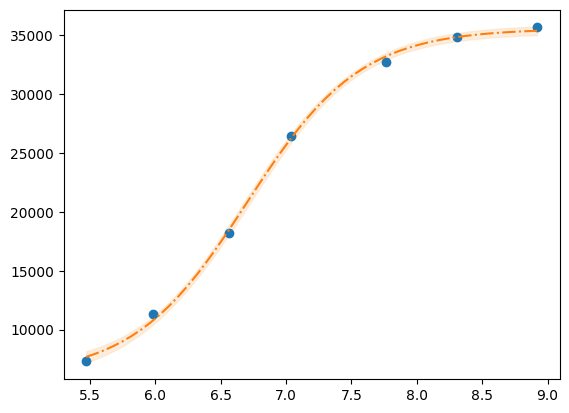

In [37]:
def fit_pH(fp):
    df = pd.read_csv(fp)

    def tit_pH(x, SA, SB, pK):
        return (SB + SA * 10 ** (pK - x)) / (1 + 10 ** (pK - x))

    mod = lmfit.Model(tit_pH)
    pars = mod.make_params(SA=10000, SB=7e3, pK=7)
    result = mod.fit(df.y2, pars, x=df.x)
    return result, df.y2, df.x, mod


# r,y,x,model = fit_pH("/home/dati/ibf/IBF/Database/Random mutag results/Liasan-analyses/2016-05-19/2014-02-20/pH/dat/C12.dat")
r, y, x, model = fit_pH("../../tests/data/H04.dat")
xfit = np.linspace(x.min(), x.max(), 50)
dely = r.eval_uncertainty(x=xfit) * 1
best_fit = r.eval(x=xfit)
plt.plot(x, y, "o")
plt.plot(xfit, best_fit, "-.")
plt.fill_between(xfit, best_fit - dely, best_fit + dely, color="#FEDCBA", alpha=0.5)
r.conf_interval(sigmas=[2])
print(r.ci_report(with_offset=False, ndigits=2))

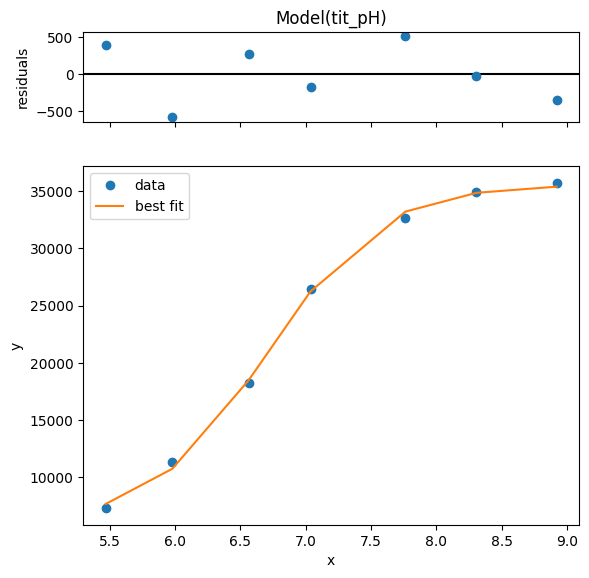

In [38]:
g = r.plot()

In [39]:
print(r.ci_report())

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 SA:-3714.13150-1540.91238-602.378536052.53269+589.59734+1459.78928+3269.42485
 SB:-2137.47758-934.62678-373.4502035544.44185+375.62906+948.44608+2211.79840
 pK:  -0.23398  -0.10021  -0.03976   6.70123  +0.03971  +0.09989  +0.23227


### using clophfit.binding

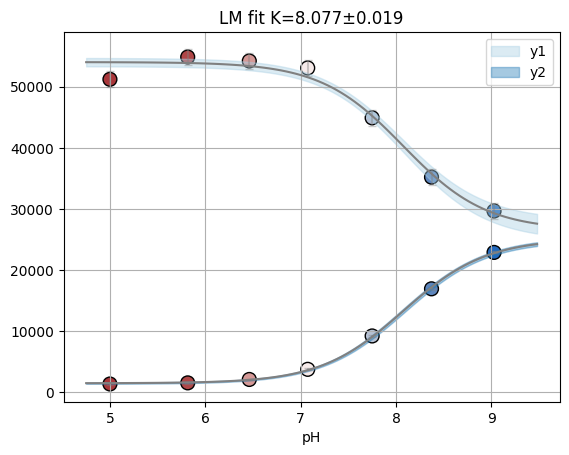

In [40]:
dictionary = df.loc[:, ["y1", "y2"]].to_dict(orient="series")
dictionary = {key: value.to_numpy() for key, value in dictionary.items()}
ds = Dataset(df.x.to_numpy(), dictionary, True)
f_res2 = fit_binding_glob(ds, True)
f_res2.figure

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.92it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.26348026 49.85368936 56.0758159  42.12187094 47.14826225]


(<Figure size 1180x1180 with 25 Axes>, [7.86, 8.1])

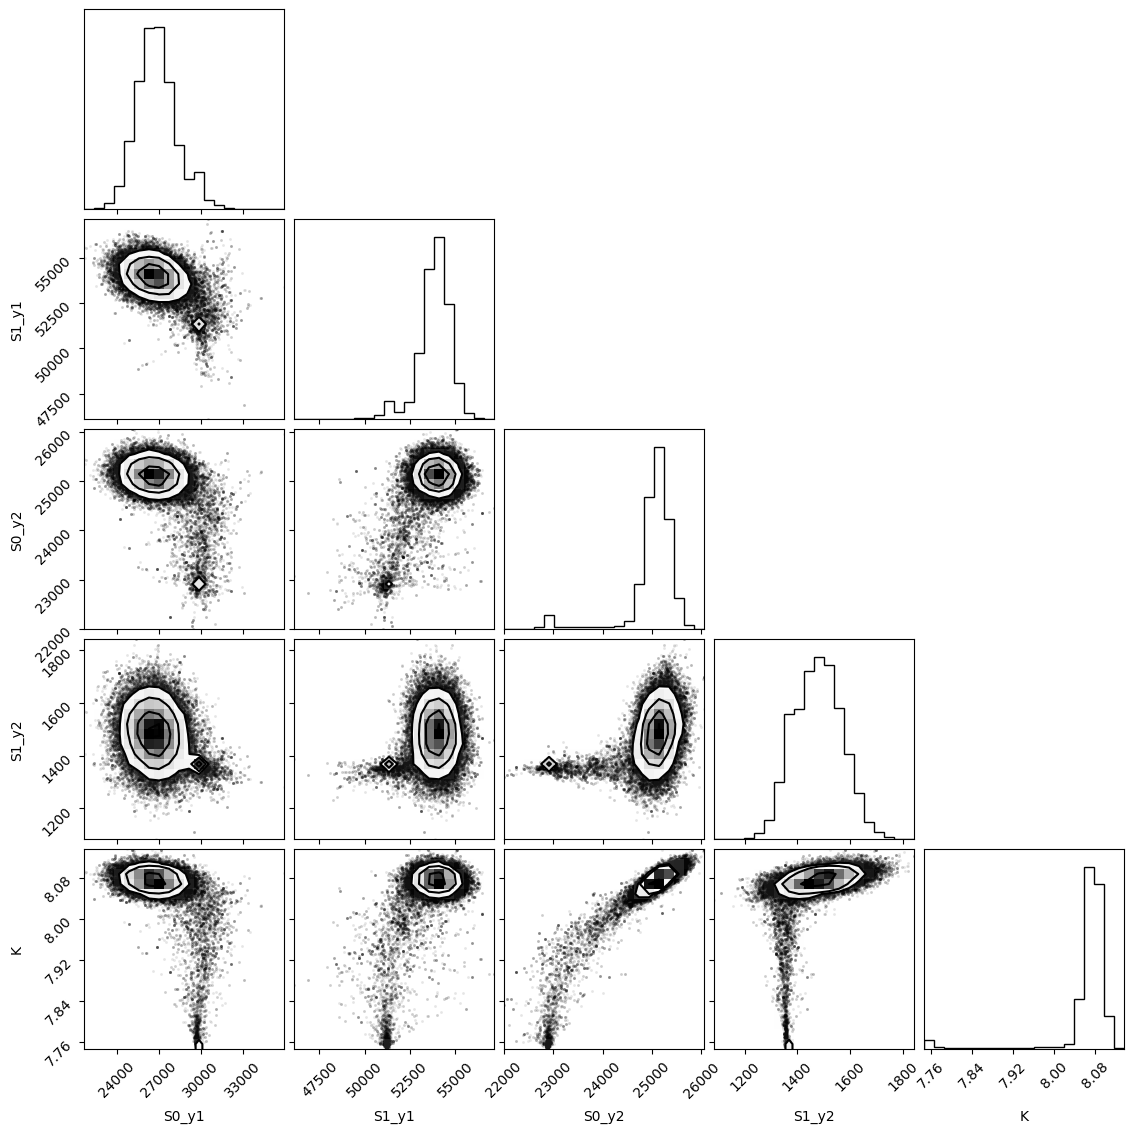

In [41]:
emcee_res2 = f_res2.mini.emcee()
plot_emcee(emcee_res2.flatchain)

## Model: example 2P Cl–ratio

    99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 R0:   0.49   0.58   0.60   0.61   0.62   0.64   0.73
 R1:  -0.30  -0.01   0.03   0.04   0.06   0.09   0.20
 Kd:   2.95  10.09  12.51  13.66  14.91  18.49  59.97


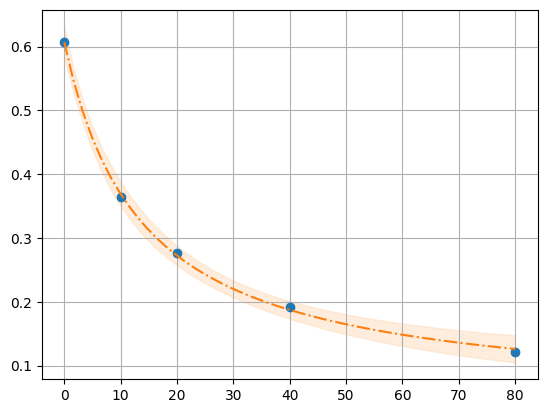

In [42]:
def fit_Rcl(fp):
    df = pd.read_table(fp)

    def R_Cl(cl, R0, R1, Kd):
        return (R1 * cl + R0 * Kd) / (Kd + cl)

    mod = lmfit.Model(R_Cl)
    pars = mod.make_params(R0=0.8, R1=0.05, Kd=10)
    result = mod.fit(df.R, pars, cl=df.cl)
    return result, df.R, df.cl, mod


r, y, x, model = fit_Rcl("../../tests/data/ratio2P.txt")
xfit = np.linspace(x.min(), x.max(), 50)
dely = r.eval_uncertainty(cl=xfit) * 3
best_fit = r.eval(cl=xfit)
plt.plot(x, y, "o")
plt.grid()
plt.plot(xfit, best_fit, "-.")
plt.fill_between(xfit, best_fit - dely, best_fit + dely, color="#FEDCBA", alpha=0.5)
r.conf_interval(sigmas=[2])
print(r.ci_report(with_offset=False, ndigits=2))

In [43]:
emcee_kws = dict(is_weighted=False, progress=False)
emcee_params = r.params.copy()
emcee_params.add(
    "__lnsigma", value=np.log(0.1), min=np.log(0.000001), max=np.log(2000.0)
)
result_emcee = model.fit(
    data=y,
    cl=x,
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

lmfit.report_fit(result_emcee)

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.84902134 43.44317898 44.43887952 91.23357575]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 5
    # variables        = 4
    chi-square         = 0.82881441
    reduced chi-square = 0.82881441
    Akaike info crit   = -0.98598469
    Bayesian info crit = -2.54823304
    R-squared          = -4.83198987
[[Variables]]
    R0:         0.60611287 +/- 0.01557085 (2.57%) (init = 0.6071065)
    R1:         0.04149025 +/- 0.02362505 (56.94%) (init = 0.04390399)
    Kd:         13.9445189 +/- 2.39070630 (17.14%) (init = 13.66125)
    __lnsigma: -4.61321296 +/- 1.23730075 (26.82%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(R1, Kd)        = -1.0000
    C(R0, __lnsigma) = -0.1074


(<Figure size 970x970 with 16 Axes>, [])

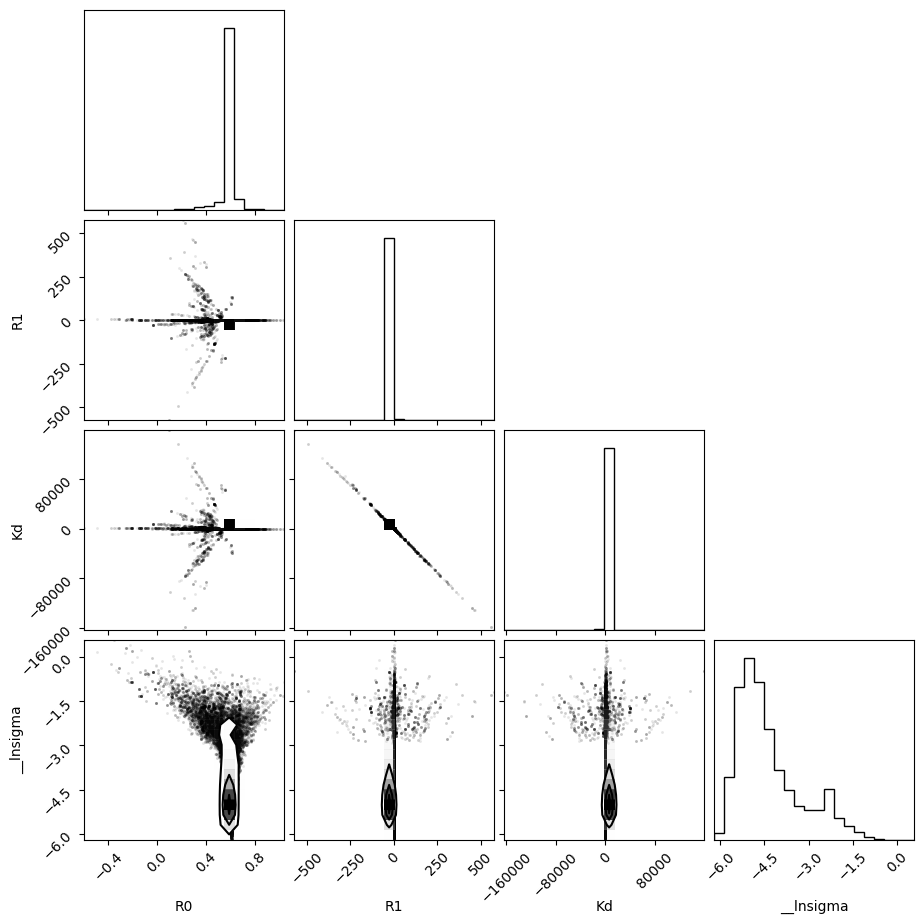

In [44]:
plot_emcee(result_emcee)

In [45]:
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum Likelihood Estimation (MLE):")
print("----------------------------------")
for ix, param in enumerate(emcee_params):
    print(f"{param}: {mle_soln[ix]:.3f}")

quantiles = np.percentile(result_emcee.flatchain["Kd"], [2.28, 15.9, 50, 84.2, 97.7])
print(f"\n\n1 sigma spread = {0.5 * (quantiles[3] - quantiles[1]):.3f}")
print(f"2 sigma spread = {0.5 * (quantiles[4] - quantiles[0]):.3f}")


Maximum Likelihood Estimation (MLE):
----------------------------------
R0: 0.607
R1: 0.045
Kd: 13.590
__lnsigma: -5.527


1 sigma spread = 1.969
2 sigma spread = 107.071


In [46]:
print_emcee(res_emcee)

NameError: name 'print_emcee' is not defined